# Analiza kretanja masine

- cilj je na osnovu skupa anotiranih tacaka nauciti algoritam da generise mapu poslova
- 1: obuciti NN tako da ume da prepoznake tacke koje pripadaju liniji i krivoj (RAD SINTEZA)
- 2: grupisati tacke u fazi linije (fazi linija je odredjena pocetnom i krajnom tackom te koeficientom pravca)
- 3: iskoristi SOM da bi se grupisali svi koeficienti pravca
- 4: na osnovu dobijenih rezultata izvrsiti korekciju fazi linija
- 5: prepoznavanje tacaka koje pripadaju servisnim putevima linearna regresija

## 1. Format ulaznih podataka

```
0 Date	
1 Time	
2 AbC	
3 AC	
4 CdE	
5 CE	
6 AbcdE	
7 AE	
8 speed	
9 cog	
10 lon	   - koordinate tacke C
11 lat	
12 segment - redni broj segmenta	
13 class - [line, curve]
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg
%matplotlib inline

def load_data(file_name):
    with open(file_name, 'r') as f:
        data = f.read()
    data_set = []    
    lines = data.split('\n')
    p = 0
    n = 0
    for line in lines[1:]:
        parts = line.split('\t')
        if len(parts)>1:
            item = []
            for i in range(1, 13):
                item.append(float(parts[i]))
            if(parts[13] == 'line'):
                item.append(float(-1))
            else:
                item.append(float(1))            
            
            data_set.append(np.array(item))            
            if(parts[13] == 'line'):
                p += 1
            else:
                n += 1
    print p, n
    data_set = np.array(data_set)
    return data_set


In [2]:
data = load_data('data/rad_podaci_etran.csv')

16541 1739


## Data

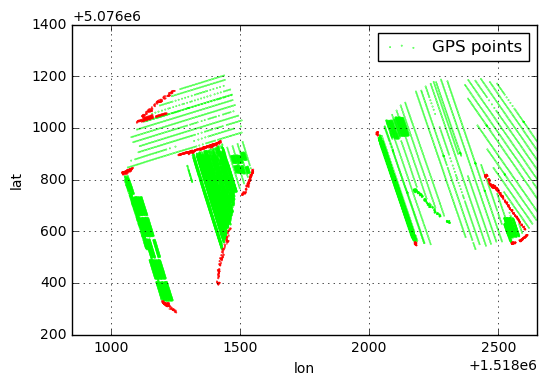

In [3]:
klon = 78847
klat = 111132

color = [(1*item==1, 1*item==-1, 0) for item in data[1:,12]]

plt.scatter(klon*data[1:,9], klat*data[1:,10], color=color, s=0.1, label='GPS points');
plt.legend()
plt.xlabel('lon')
plt.ylabel('lat')
plt.axis('equal')
plt.grid(True)

## Grupisanje tačaka u linije

Linearni model po parametrima W i b


### Pristupi:

- 1) Tensorflow sa Adam optimizatorom
- 2) Klasicni polyfit
- 3) Avg izmisljen


### 1) Tensorflow

In [4]:
import numpy.linalg as linalg
import tensorflow as tf
rng = np.random
import random
import time

# Parameters
learning_rate = 0.1
training_epochs = 100
batch = 50
display_step = 50


In [5]:
X = tf.placeholder("float")
Y = tf.placeholder("float")

# Set model weights
W = tf.Variable(rng.randn(), name="weight")
b = tf.Variable(rng.randn(), name="bias")

# Linear model
pred = tf.add(tf.multiply(X, W), b)

# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/50 #/(2*n_samples)

# Gradient descent
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

def process_line_tf(rb, points):
    start = time.time()
    points = np.array(points)
    lon, lat = klon*points[:,9], klat*points[:,10]
    train_X = lon - lon.mean(axis=0)
    train_Y = lat - lat.mean(axis=0)
    n_samples = train_X.shape[0]

    train_subset = np.random.choice(train_X.shape[0], 10)    
    
    # Fit all training data
    for epoch in range(training_epochs):
        for (x, y) in zip(train_X[train_subset], train_Y[train_subset]):
            sess.run(optimizer, feed_dict={X: x, Y: y})

        c = sess.run(cost, feed_dict={X: train_X, Y:train_Y})                
        if(c<0.5):
            break          
            
    if(debug):
        training_cost = sess.run(cost, feed_dict={X: train_X, Y: train_Y})
        print(n_samples, "Training cost=", training_cost, "W=", sess.run(W), "b=", sess.run(b), '\n')
        # Graphic display
        plt.plot(train_X, train_Y, 'ro', label='Original data')
        plt.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fitted line')
        plt.legend()
        plt.show()    
    
    #training_cost = sess.run(cost, feed_dict={X: train_X, Y: train_Y})
    #print(rb, n_samples, training_cost, sess.run(W), sess.run(b))
    #print(rb, n_samples, sess.run(W), sess.run(b))
    end = time.time()
    return sess.run(W), sess.run(b), end-start

In [6]:
debug = False

# Launch the graph
sess = tf.Session()
sess.run(init)

In [7]:
%%time
line = []
rb = -1
for el in data:
    if(rb>10):
        break
    if el[12]==1: # preskociti tacke koje ne pripadaju linijama
        continue
    else:
        if el[11] == rb:
            line.append(el)
        else:
            if(len(line)>10):
                process_line_tf(rb, line)
            rb = el[11]
            line = []


CPU times: user 1.03 s, sys: 132 ms, total: 1.16 s
Wall time: 949 ms


In [8]:
sess.close() 

### 2) Polyfit

In [9]:
def process_line(rb, points):
    start = time.time()
    points = np.array(points)
    lon, lat = klon*points[:,9], klat*points[:,10]
    train_X = lon
    train_Y = lat
    train_X = lon - lon.mean(axis=0)
    train_Y = lat - lat.mean(axis=0)
    n_samples = train_X.shape[0]

    w, b = np.polyfit(train_X, train_Y, 1)
    end = time.time()
    
    return w,b,end-start
    
    #print(rb, n_samples, w, b)
    
    # Graphic display
    #plt.plot(train_X, train_Y, 'ro', label='Original data')
    #plt.plot(train_X, w * train_X + b, label='Fitted line')
    #plt.legend()
    #plt.show()    



In [10]:
%%time

line = []
rb = -1
for el in data:
    if(rb>200):
        break
    if el[12]==1: # preskociti tacke koje ne pripadaju linijama
        continue
    else:
        if el[11] == rb:
            line.append(el)
        else:
            if(len(line)>10):
                process_line(rb, line)
            rb = el[11]
            line = []

CPU times: user 80 ms, sys: 4 ms, total: 84 ms
Wall time: 175 ms


## 3) Avg - izmisljen

In [92]:
def process_line_i(rb, points):
    start = time.time()
    points = np.array(points)
    lon, lat = klon*points[:,9], klat*points[:,10]
    train_X = lon
    train_Y = lat
    lonm = lon.mean(axis=0)
    latm = lat.mean(axis=0)
    train_X = lon - lonm
    train_Y = lat - latm
    #n_samples = train_X.shape[0]

    train_subsetA = np.random.choice(train_X.shape[0], 6)    
    train_subsetB = np.random.choice(train_X.shape[0], 6)    
    
    # Fit all training data
    w = 0
    b = 0
    n = 36
    end = False
    for (xa, ya) in zip(train_X[train_subsetA], train_Y[train_subsetA]):
        for (xb, yb) in zip(train_X[train_subsetB], train_Y[train_subsetB]):
            if(xa!=xb):
                ww = (ya-yb)/(xa-xb)
                bb = ya-ww*xa
                w += ww
                b += bb
    '''
    xm  = -1
    xM = -1
    for (xa, ya) in zip(train_X, train_Y):
        if(xm == -1):
            xm = xa
            xM = xa
        xm = min([xm, xa, xb])
        xM = max([xM, xa, xb])
    '''            
                
    w = w/n
    b = b/n
    end = time.time()
    
    return w,b,end-start

    ##print(rb, n_samples, w, b)
    #xline = np.array([xm, xM])    
    
    ## Graphic display
    #plt.plot(train_X, train_Y, 'ro', label='Original data')
    #plt.plot(train_X, w * train_X + b, label='Fitted line')
    #plt.scatter(xline, w * xline+ b,s=80, label='Fuzzy line ends', )
    
    #plt.legend()
    #plt.show()   

In [93]:
%%time

line = []
rb = -1
for el in data:
    if(rb>10):
        break
    if el[12]==1: # preskociti tacke koje ne pripadaju linijama
        continue
    else:
        if el[11] == rb:
            line.append(el)
        else:
            if(len(line)>10):
                process_line_i(rb, line)
            rb = el[11]
            line = []

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.56 ms


## Experiments


In [94]:
debug = False

# Launch the graph
sess = tf.Session()
sess.run(init)

In [95]:
%%time
np.random.seed(seed=42)

line = []
rb = -1
i = 0
rez = []
for el in data:
    if(rb>200):
        break
    if el[12]==1: # preskociti tacke koje ne pripadaju linijama
        continue
    else:
        if el[11] == rb:
            line.append(el)
        else:
            if(len(line)>10):
                (w1,b1,t1)=process_line(rb, line)
                (w2,b2,t2)=process_line_tf(rb, line)
                (w3,b3,t3)=process_line_i(rb, line)
                rez.append(np.array([i, len(line), w1, b1, t1, w2, b2, t2, w3, b3, t3]))
                i += 1
                #print i, abs(w1-w2), abs(w1-w3), len(line)
            rb = el[11]
            line = []
rez = np.array(rez)


CPU times: user 29.7 s, sys: 2.99 s, total: 32.7 s
Wall time: 19.1 s


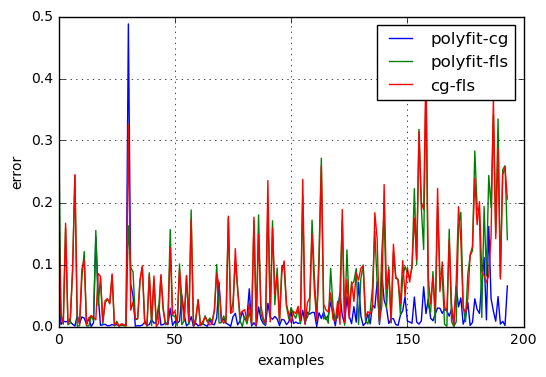

In [96]:
plt.plot(rez[:,0], np.abs(rez[:,2]-rez[:,5]), label='polyfit-cg')
plt.plot(rez[:,0], np.abs(rez[:,2]-rez[:,8]), label='polyfit-fls')
plt.plot(rez[:,0], np.abs(rez[:,5]-rez[:,8]), label='cg-fls')

plt.xlabel('examples')
plt.ylabel('error')

plt.legend()
plt.grid()
plt.show()   

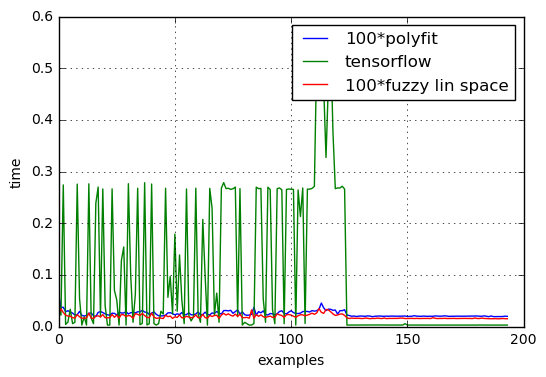

In [97]:
plt.plot(rez[:,0], 100*rez[:,4], label='100*polyfit')
plt.plot(rez[:,0], rez[:,7], label='tensorflow')
plt.plot(rez[:,0], 100*rez[:,10], label='100*fuzzy lin space')

plt.xlabel('examples')
plt.ylabel('time')

plt.legend()
plt.grid()
plt.show()  

## Polyfit - FLS algoritam

Poređenje vremena izvršavanja dva algoritma. Oba algoritma se obucavaju na istom skupu podataka sa sličnom tačnošću.

Na slici se vidi da je za neke primere vreme izvrsavanja novog algoritma manje od vremena uobicajenim polyfit algoritmom.

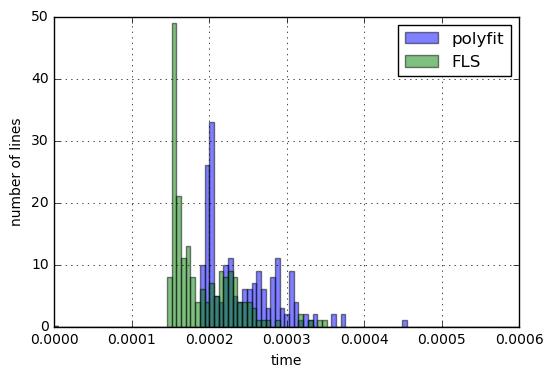

In [98]:

bins = np.linspace(0, 0.0006, 100)

plt.hist(rez[:,4], bins, alpha=0.5, label='polyfit')
#plt.hist(rez[:,7], bins, alpha=0.5, label='tensorflow')
plt.hist(rez[:,10], bins, alpha=0.5, label='FLS')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('time')
plt.ylabel('number of lines')
plt.show()


# Poređenje sva tri predložena pristupa

Primena Computational graph pristupa sa ADAM optimizatorom i implementacijom u tensorflow.

Na slici se vidi da je vreme tog pristupa znacajno losije u odnosu na prethodna dva pristupa.


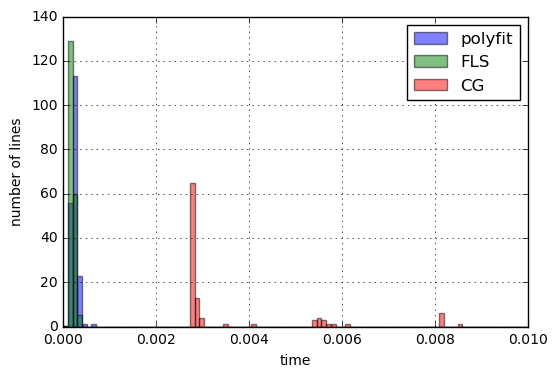

In [99]:
bins = np.linspace(0, 0.01, 100)

plt.hist(rez[:,4], bins, alpha=0.5, label='polyfit')
plt.hist(rez[:,10], bins, alpha=0.5, label='FLS')
plt.hist(rez[:,7], bins, alpha=0.5, label='CG')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('time')
plt.ylabel('number of lines')
plt.show()

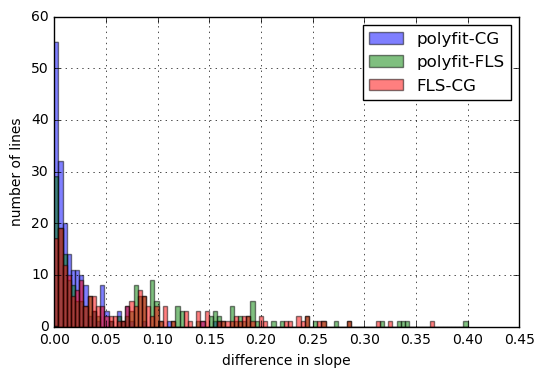

In [100]:
bins = np.linspace(0, 0.4, 100)

plt.hist(np.abs(rez[:,2]-rez[:,5]), bins, alpha=0.5, label='polyfit-CG')
plt.hist(np.abs(rez[:,2]-rez[:,8]), bins, alpha=0.5, label='polyfit-FLS')
plt.hist(np.abs(rez[:,5]-rez[:,8]), bins, alpha=0.5, label='FLS-CG')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('difference in slope')
plt.ylabel('number of lines')
plt.show()

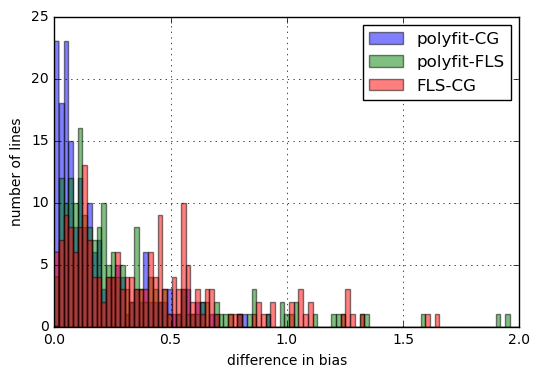

In [101]:
bins = np.linspace(0, 2, 100)

plt.hist(np.abs(rez[:,3]-rez[:,6]), bins, alpha=0.5, label='polyfit-CG')
plt.hist(np.abs(rez[:,3]-rez[:,9]), bins, alpha=0.5, label='polyfit-FLS')
plt.hist(np.abs(rez[:,6]-rez[:,9]), bins, alpha=0.5, label='FLS-CG')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('difference in bias')
plt.ylabel('number of lines')
plt.show()

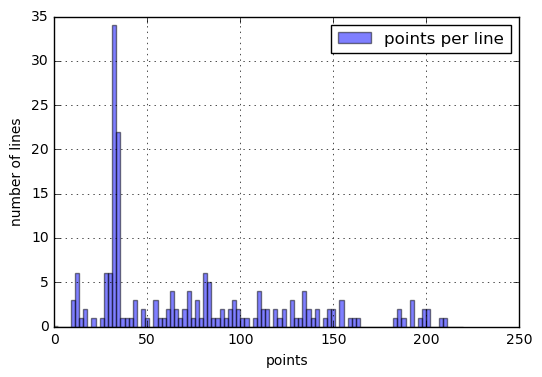

In [102]:
bins = np.linspace(0, 220, 100)

plt.hist(rez[:,1], bins, alpha=0.5, label='points per line')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('points')
plt.ylabel('number of lines')
plt.show()